In [4]:
import torch
import numpy as np
from scipy.spatial.distance import squareform
from scipy.stats import wasserstein_distance
from collections import OrderedDict
from fabrics_ranking_functions import *

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import pandas as pd
def delta_emd(A):
    _,T,D=A.shape
    L=[torch.tensor([[empirical_emd(A[:,t-1,[d]],A[:,t,[d]],False)] for t in range(1,T)])\
    for d in range(D)]
    return torch.hstack(L)
import matplotlib.pyplot as plt

In [5]:
#Load latents
# Stress Path directories
Latent_stress_directory=['Latents/S1_latent.pth',\
        'Latents/S2_latent.pth',\
        'Latents/S3_latent.pth',\
        'Latents/S4_latent.pth']
LatentS1=torch.load(Latent_stress_directory[0])
LatentS2=torch.load(Latent_stress_directory[1])
LatentS3=torch.load(Latent_stress_directory[2])
LatentS4=torch.load(Latent_stress_directory[3])
P,N,T,D=LatentS1.shape
#########################       
UT_S1_z,UC_S1_z,SH_S1_z=[LatentS1[0],LatentS1[1],LatentS1[2]]
UT_S2_z,UC_S2_z,SH_S2_z=[LatentS2[0],LatentS2[1],LatentS2[2]]
UT_S3_z,UC_S3_z,SH_S3_z=[LatentS3[0],LatentS3[1],LatentS3[2]]
UT_S4_z,UC_S4_z,SH_S4_z=[LatentS4[0],LatentS4[1],LatentS4[2]]
#Load fabrics
fabrics_directory=['fabrics/Based_on_Bw.pt',\
        'fabrics/Based_on_Aw.pt',\
        'fabrics/Based_on_Dw.pt']
cat_fabrics=torch.tensor([])
for fabric_path in fabrics_directory:
    f_dict=torch.load(fabric_path)
    print(f_dict.keys())
    
    for k,item in f_dict.items():
        cat_fabrics=torch.cat([cat_fabrics,item],dim=-1)

dict_keys(['nodal degree', 'clustering coefficient', 'betweenness centrality'])
dict_keys(['strength', 'area betweenness', 'local efficiency', 'global efficiency', 'max crack area'])
dict_keys(['eccentricity', 'closeness centrality', 'max crack length'])


C:\Users\DanielChou\AppData\Local\Temp\ipykernel_140680\701023025.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LatentS1=torch.load(Latent_stress_directory[0])
C:\User

# Select fabric for Boundary conditions: 
bc_id=\
0:Uniaxial Tension,\
1:Uniaxial Compression,\
2:Simple Shear

In [6]:
bc_id=2
BC_f=cat_fabrics[bc_id]
BC_f[:,:,bc_id].shape
BC_S1_z,BC_S2_z,BC_S3_z,BC_S4_z=[LatentS1[bc_id],LatentS2[bc_id],LatentS3[bc_id],LatentS4[bc_id]]
#Step2. EMD
BC_S1_z_emd=delta_emd(BC_S1_z)
BC_S2_z_emd=delta_emd(BC_S2_z)
BC_S3_z_emd=delta_emd(BC_S3_z)
BC_S4_z_emd=delta_emd(BC_S4_z)
BC_f_emd=delta_emd(BC_f)
#Step3. DTW
dtwS1=dtw_matrix_for_EMDarrays(BC_S1_z_emd, BC_f_emd)
dtwS2=dtw_matrix_for_EMDarrays(BC_S2_z_emd, BC_f_emd)
dtwS3=dtw_matrix_for_EMDarrays(BC_S3_z_emd, BC_f_emd)
dtwS4=dtw_matrix_for_EMDarrays(BC_S4_z_emd, BC_f_emd)
#Step4. DTW average
dtwg=torch.stack([dtwS1,dtwS2,dtwS3,dtwS4])
dtw_ave=dtwg.mean(0)

# Select id of fabric descriptor

In [7]:
f_id=4
weight_vector=torch.softmax(1/dtw_ave[:,f_id],dim=0)#1/dtw_ave[:,f_id]
z_ids=[i.item() for i in torch.where(weight_vector>(weight_vector.mean()+2*weight_vector.std()))[0]]
line_value = weight_vector.mean() + 2 * weight_vector.std()
if z_ids==[]:
    z_ids=[i.item() for i in torch.where(weight_vector>(weight_vector.mean()+1.5*weight_vector.std()))[0]]
    line_value = weight_vector.mean() + 1.5 * weight_vector.std()

# Fig 1: Latent Variables with weight exceed threshold

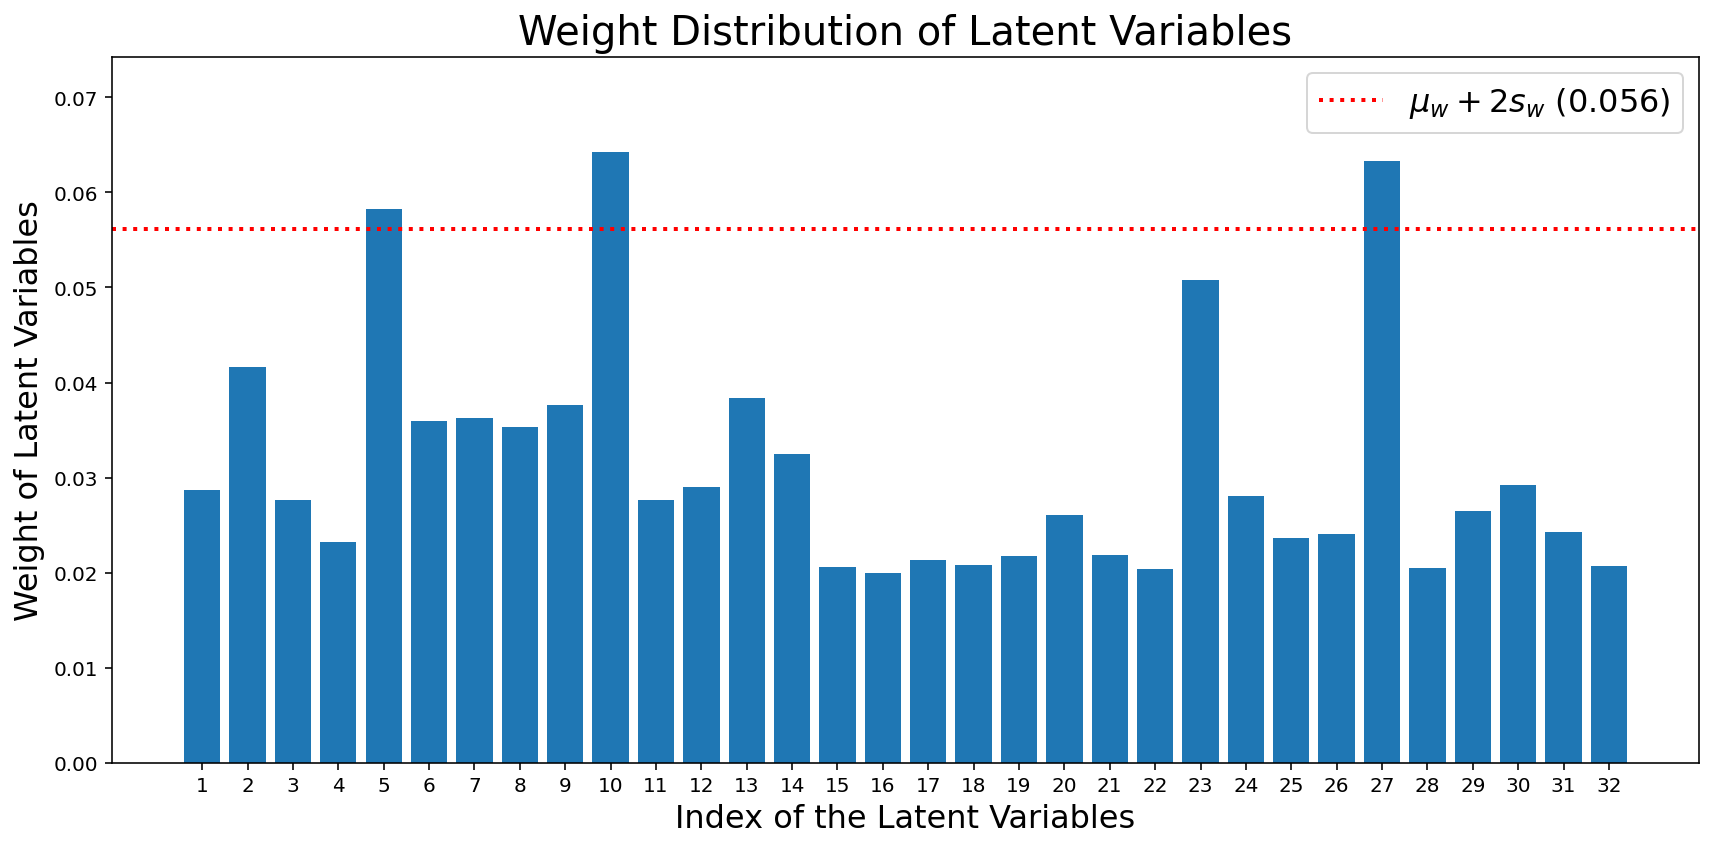

[4, 9, 26]


tensor([1.5294, 0.9752, 1.6244, 2.2736, 0.7339, 1.1358, 1.1278, 1.1588, 1.0804,
        0.6848, 1.6247, 1.5021, 1.0592, 1.2854, 3.1132, 3.4272, 2.7838, 3.0042,
        2.6411, 1.7981, 2.6387, 3.2201, 0.8169, 1.5816, 2.1697, 2.0846, 0.6919,
        3.1682, 1.7481, 1.4887, 2.0614, 3.0722])

In [8]:

plt.figure(figsize=(12, 6), dpi=144)  # Increased figure size for better readability
bars = plt.bar(np.arange(1, len(weight_vector) + 1), weight_vector, width=0.8)  # X-axis indices start from 1

plt.axhline(y=line_value, color='r', linestyle=':', linewidth=2, label=r'$\mu_w + 2s_w$ ({:.3f})'.format(line_value))

plt.xticks(np.arange(1, len(weight_vector) + 1))
plt.xlabel('Index of the Latent Variables', fontsize=16)
plt.ylabel('Weight of Latent Variables', fontsize=16)
plt.title('Weight Distribution of Latent Variables', fontsize=20)

plt.legend(fontsize=16)

plt.ylim(0, max(weight_vector)+0.01) 

plt.tight_layout()
plt.show()

print(z_ids)
dtw_ave[:,f_id]

# Fig 2: Temporal Derivation of fabric descriptor and latent variables 

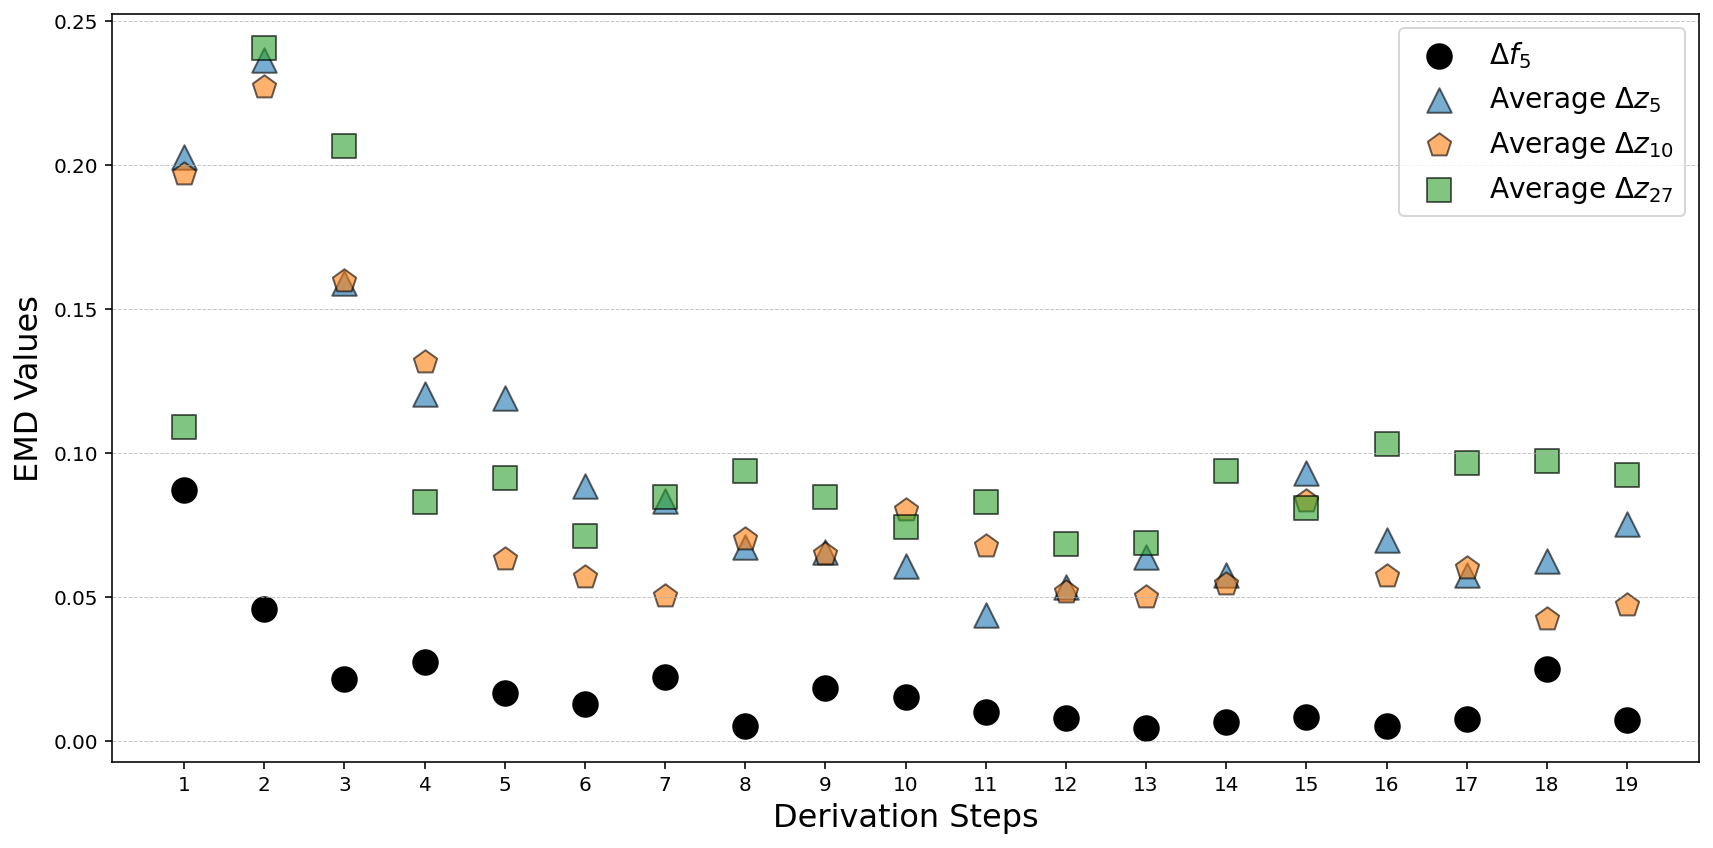

In [9]:
emd_f=BC_f_emd[:,f_id]
point_style=['^','p','s','l']
plt.figure(figsize=(12, 6), dpi=144)
plt.scatter(range(1, 20), emd_f, label=r'$\Delta f_{' + str(f_id + 1) + '}$',s=150,c='k')
for z_id,ps in zip(z_ids,point_style):
    emd_zs = [BC_S1_z_emd[:, z_id], BC_S2_z_emd[:, z_id], BC_S3_z_emd[:, z_id], BC_S4_z_emd[:, z_id]]
    mean_emd_z = torch.stack(emd_zs).mean(0)
    plt.scatter(range(1, 20), mean_emd_z, label=r'Average $\Delta z_{' + str(z_id + 1) + '}$',marker=ps,s=150,edgecolors='k',alpha=0.6)

plt.xlabel('Derivation Steps', fontsize=16)
plt.ylabel('EMD Values', fontsize=16)
plt.xticks(range(1, 20))
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()